# ASSIGNMENT #4 - SURFACE WEATHER DATA #
Due: 31 March 2024 @ 11:59p

Purpose:\
The purpose of this assignment is to continue to strengthen skills with reading in data by reading in surface observations from a text file.  The data is then plotted on a map to begin to familiarize with plotting weather data on maps.

Overview:\
In this assignment you will read in surface weather data, quality control that data, and plot that data .


| | UPDATE TO YOUR INFORMATION | 
| :- | :- |
| Created By | Jared W. Marquis |
| Creation Date | 18 January 2024 |
| Course | ATSC 270 - Computer Concepts in Meteorology |

In [1]:
### UPDATE TO YOUR INFORMATION ###
#information allowing anyone with the code to print the author and contact information
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

### IMPORT REQUIRED LIBRARIES ###

In [2]:
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout
from metpy.io import metar

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### OPEN OBSERVATIONS TEXT FILE ###
Open the text file containing the surface observations using the metpy metar reader -> metar.parse_metar_file(filename).

In [3]:
fileName = "metar_20240112_2100.txt"
data = metar.parse_metar_file(fileName, year = 2024, month =1)

data["air_temperature"] = data["air_temperature"] * (9/5) +32

data["dew_point_temperature"] = data["dew_point_temperature"] *(9/5) +32


print(data.loc['KBFI'])

station_id                                         KBFI
latitude                                          47.55
longitude                                       -122.32
elevation                                           4.0
date_time                           2024-01-12 20:53:00
wind_direction                                     10.0
wind_speed                                          7.0
wind_gust                                           NaN
visibility                                     16093.44
current_wx1                                         NaN
current_wx2                                         NaN
current_wx3                                         NaN
low_cloud_type                                      FEW
low_cloud_level                                  3400.0
medium_cloud_type                                   OVC
medium_cloud_level                               6000.0
high_cloud_type                                     NaN
high_cloud_level                                

### REMOVE DATA THAT IS INCOMPLETE ###
Just remove data with no wind direction or wind speed.

In [4]:
data = data.dropna(how = 'any', subset=['wind_direction','wind_speed'])
print(data)

           station_id  latitude   longitude  elevation           date_time  \
station_id                                                                   
KGYH             KGYH     34.75  -82.380000      292.0 2024-01-12 20:47:00   
KMFV             KMFV     37.63  -75.770000       15.0 2024-01-12 20:55:00   
KPLD             KPLD     40.45  -84.983333      282.0 2024-01-12 20:55:00   
KIKT             KIKT     28.52  -88.280000       25.0 2024-01-12 20:50:00   
PAKU             PAKU     70.31 -149.580000        2.0 2024-01-12 20:45:00   
...               ...       ...         ...        ...                 ...   
OIYY             OIYY     31.90   54.280000     1236.0 2024-01-12 21:50:00   
ORNI             ORNI     31.98   44.400000       53.0 2024-01-14 21:00:00   
NFTV             NFTV    -18.57 -173.970000       71.0 2024-01-12 21:00:00   
NFTL             NFTL    -19.78 -174.330000        3.0 2024-01-12 21:00:00   
NFTF             NFTF    -21.23 -175.150000       38.0 2024-01-1

### PLOT MAP ###

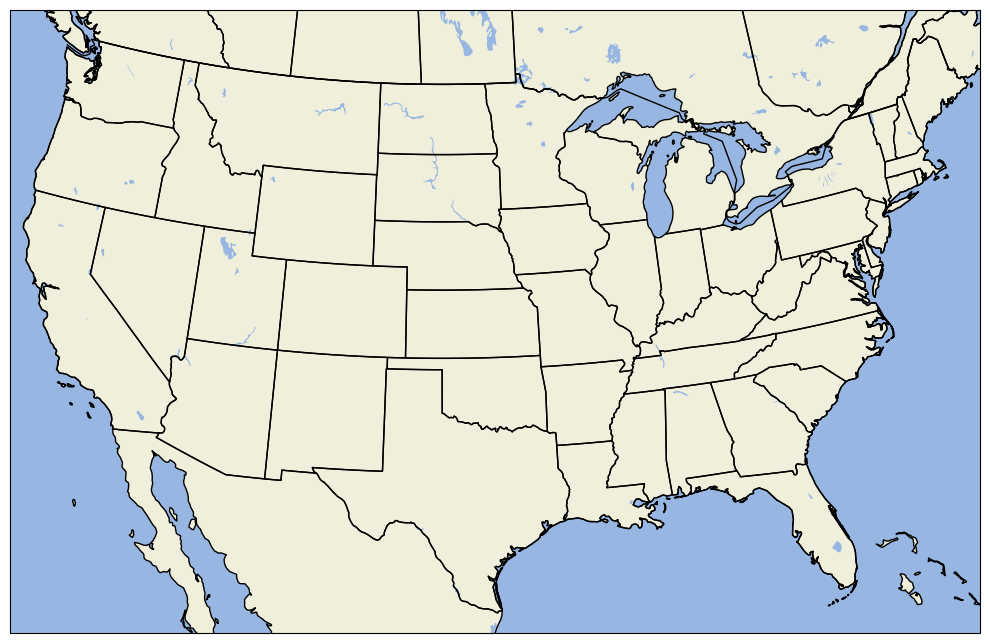

In [5]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize = (10,10), dpi =100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#save the map as empty_map.png
plt.savefig("EmptyMap.png")

### PLOT A NEW MAP BUT ADD SURFACE OBS LOCATIONS ###

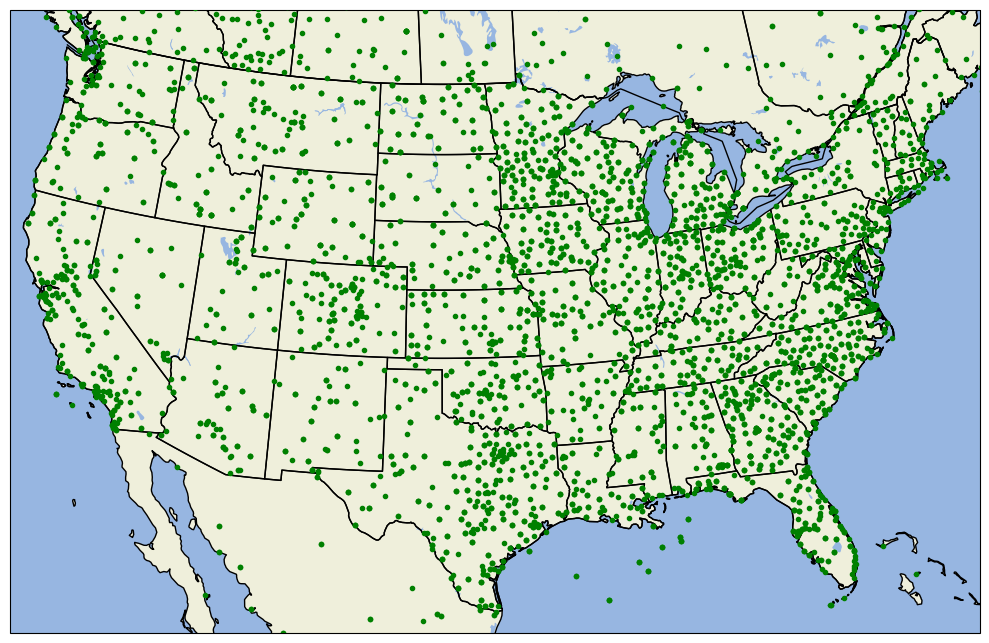

In [6]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize = (10,10), dpi =100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND, zorder = 1)
ax.add_feature(cfeature.OCEAN, zorder = 0)
ax.add_feature(cfeature.LAKES, zorder = 2)
ax.add_feature(cfeature.COASTLINE, zorder = 3)
ax.add_feature(cfeature.STATES, zorder = 3)
ax.add_feature(cfeature.BORDERS, zorder = 3)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#save the map as empty_map.png


#plot surface obs using scatter plot

ax.scatter(data.longitude, data.latitude, transform=ccrs.PlateCarree(), color= "green", marker = ".", zorder = 9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig("obs_locations.png", bbox_inches = "tight")

### WAY TOO MANY OBS ###
There are way too many obs for us to be able to actually see what the weather is.  We need to "thin" the obs in areas of very high densiy.

We'll do this using the *metpy.calc.reduce_point_density* function.

Find a density that works well for you.  The units for density are meters, so 100000 is roughly one observation/100km.


In [7]:
#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)

#now thin the data
thinData = data[mpcalc.reduce_point_density(locs, 250000)]

### SAVE OBS LOCATIONS ON NEW MAP ###

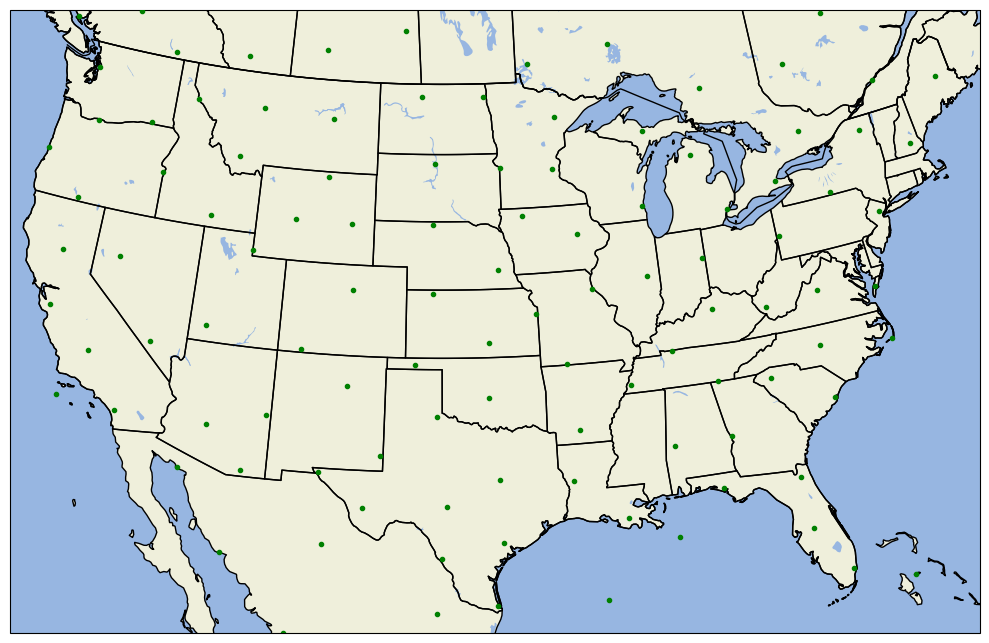

In [8]:
#save the map as obs_locations_thinned.png
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize = (10,10), dpi =100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND, zorder = 1)
ax.add_feature(cfeature.OCEAN, zorder = 0)
ax.add_feature(cfeature.LAKES, zorder = 2)
ax.add_feature(cfeature.COASTLINE, zorder = 3)
ax.add_feature(cfeature.STATES, zorder = 3)
ax.add_feature(cfeature.BORDERS, zorder = 3)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()

#save the map as empty_map.png


#plot surface obs using scatter plot

ax.scatter(thinData.longitude, thinData.latitude, transform=ccrs.PlateCarree(), color= "green", marker = ".", zorder = 9)

fig.tight_layout()
#save the map as obs_locations.png
plt.savefig("thinned_data_locations.png", bbox_inches = "tight")

### ONCE YOU'RE HAPPY WITH THE DENSITY, PLOT SURFACE STATIONS ###
For this use the *StationPlot* object in metpy -> https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html

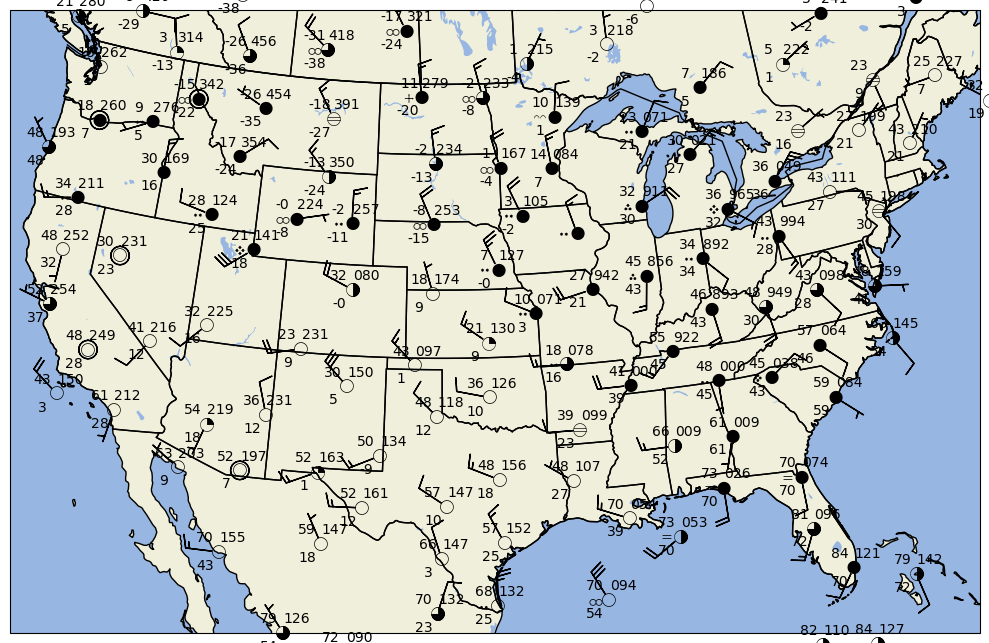

In [18]:
#save the map as simple_surface_obs.png
#save the map as obs_locations_thinned.png
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize = (10,10), dpi =100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND, zorder = 1)
ax.add_feature(cfeature.OCEAN, zorder = 0)
ax.add_feature(cfeature.LAKES, zorder = 2)
ax.add_feature(cfeature.COASTLINE, zorder = 3)
ax.add_feature(cfeature.STATES, zorder = 3)
ax.add_feature(cfeature.BORDERS, zorder = 3)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

fig.tight_layout()



stationPlots = StationPlot (ax, thinData["longitude"], thinData["latitude"], transform = ccrs.PlateCarree(), zorder = 5)
simple_layout.plot(stationPlots,thinData)



fig.tight_layout()
plt.savefig("simple_surface_obs.png", bbox_inches = "tight")

### PLOT NORTHERN PLAINS ###
Now we are going to focus on the Northern Great Plains and make a custom layout.<br>
We will set the extent to 150W to 90W and 40N to 50N.<br>
We will also need to re-thin the data since we will be zoomed in and can see more obs.<br><br>
Data that will be plotted:<br>
 - Temperature in the top left
 - Dewpoint in bottom left
 - Pressure in top right
 - Station ID in bottom right
 - Current weather on left
 - Visibility in miles on far left
 - Wind barb in black
 - Wind gust barb in red

In [46]:
#rethin data (90km works well)
rethinnedData = data[mpcalc.reduce_point_density(locs, 90000)]
#print(rethinnedData)

In [45]:
#create wind gust vectors
#do this by multiplying each component by the ratio of gust to speed
u = rethinnedData.eastward_wind.values * units("knots")
v = rethinnedData.northward_wind.values * units("knots")
gust = rethinnedData.wind_gust.values * units("knots")
mpcalc.wind_direction(u,v)
wdir = mpcalc.wind_direction (u,v)
ug, vg = mpcalc.wind_components(gust,wdir)

print(ug[5])

24.6201938253052 knot


TextCollection

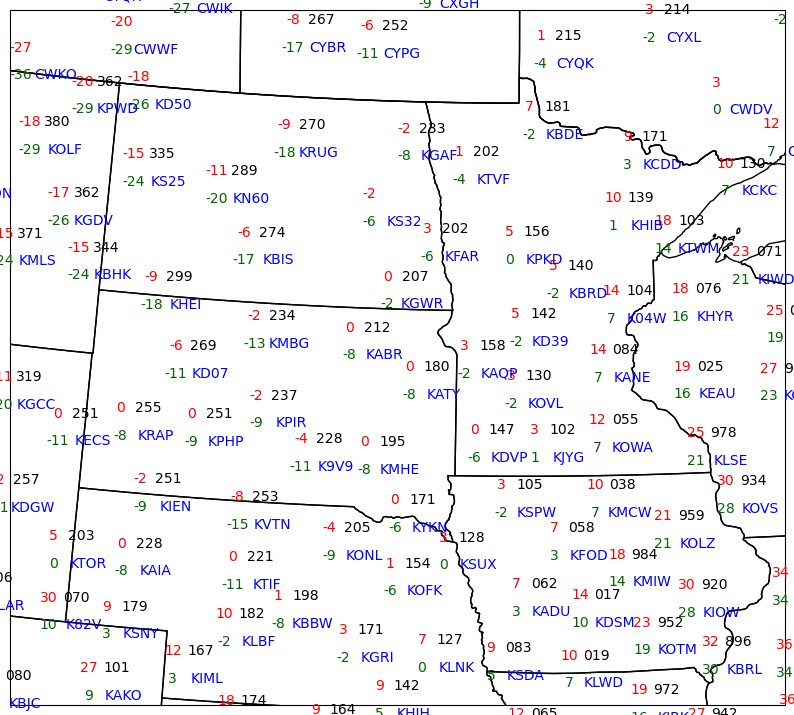

In [76]:
#map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the Northern Plains
ax.set_extent((-105, -90, 40, 50))


#create stationplot (will actually need to create 2 to handle wind gusts)
stationPlots = StationPlot (ax, rethinnedData["longitude"], rethinnedData["latitude"], transform = ccrs.PlateCarree())

#temperature in red
stationPlots.plot_parameter ((-1,1), rethinnedData["air_temperature"].values, color = 'red')
#dewpoint in dark green
stationPlots.plot_parameter ((-1,-1), rethinnedData["dew_point_temperature"].values, color = 'darkgreen')
#pressure (need to format to be the final 3 digits)
stationPlots.plot_parameter ((1,1),rethinnedData["air_pressure_at_sea_level"].values, color = "black",
                             formatter = lambda p: format (10*p, ".0f")[-3:])
#station ID in dark blue
stationPlots.plot_text ((1.5,-1), rethinnedData["station_id"], color = 'blue')
#visibility in black (need to convert from meters to miles)
stationPlots.plot_parameter ((-1,-1), rethinnedData["dew_point_temperature"].values, color = 'darkgreen')
#wind gust in red

#wind in black

#cloud cover

#current weather

#save the map as surface_obs.png
